In [1]:
import collections
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import spacy
import nltk
from nltk.stem import WordNetLemmatizer

from utils import (
    drop_spam_rows,
    remove_digits,
    remove_prefixed_words,
    contract_spaces,
    remove_single_characters,
    remove_special_characters,
)

# Load spaCy Spanish trained pipeline

In [2]:
try:
    sp = spacy.load("es_core_news_sm")
except OSError:
    !python3 -m spacy download es_core_news_sm
    sp = spacy.load("es_core_news_sm")

# Load texts

In [3]:
dataset_path = "dataset_balcones.csv"
dataset = pd.read_csv(dataset_path, sep=";")
texts = dataset["text"]

In [4]:
texts

0       Si os falta papel higiénico, las banderas de E...
1       Himno de España, aplausos a sanitarios, el dis...
2       Hoy a las 22.00 se convocó salir al balcón par...
3       "Aplausos en balcones de toda España para agra...
4       "Aplausos en balcones de toda España para agra...
                              ...                        
7263    Quiero que se acabe todo esto cuanto antes tam...
7264    El resumen es:\n\n1)Hay algo de vida inteligen...
7265    madre mía estoy acordándome que cuando era peq...
7266    Esta  semana solo en mi calle y observando des...
7267    Estáis ya preparados con el móvil en el balcón...
Name: text, Length: 7268, dtype: object

# Preprocessing

In [5]:
PUNCTUATION_MARKS = string.punctuation + "¿" + "¡" + "..." + "…" + " "

UNDESIRED_WORDS = [
    "balcón",
    "balcones",
    "balcon",
    "si",
    "haber",
    "ser",
    "quedateencasa",
    "yomequedoencasa",
    "tirar"
]

STOP_WORDS = nltk.corpus.stopwords.words("spanish") + UNDESIRED_WORDS

UNDESIRED_PREFIXES = ["@", "#", "http", "jaj", "xd", "xD", "XD", "pic", "twitter", "tw", "com"]


def tokenize(text):
    """Get tokenized text."""
    return " ".join(
        [
            token.lemma_ for token in sp(text)
            if token.text not in PUNCTUATION_MARKS
            and token.text not in STOP_WORDS
        ]
    )

def preprocess_text(text):
    """Apply transformations to text."""
    text = text.lower()
    for prefix in UNDESIRED_PREFIXES:
            text = remove_prefixed_words(prefix, text)
    text = remove_special_characters(text)
    text = remove_single_characters(text)
    text = remove_digits(text)
    text = contract_spaces(text)
    return tokenize(text)

In [6]:
texts_preprocessed = texts.apply(lambda x: preprocess_text(x))

In [7]:
texts_preprocessed.head()

0    faltar papel higiénico bandera españa colgado ...
1    himno españa aplauso sanitario discurso lopera...
2    hoy convocar salir aplaudir labor sanitario de...
3              aplauso todo españa agradecer sanitario
4              aplauso todo españa agradecer sanitario
Name: text, dtype: object

# TF-IDF Vectorizer

In [8]:
tf = TfidfVectorizer(
    stop_words=(STOP_WORDS),
    max_features=None,
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 3)
)
X = tf.fit_transform(texts_preprocessed)

In [9]:
feature_names = tf.get_feature_names_out()
words = np.array(tf.get_feature_names_out())
matrix = pd.DataFrame(X.toarray(), columns=feature_names)

In [10]:
words

array(['abajo', 'abascal', 'abeja', ..., 'útil', 'útil habitación',
       'útil habitación baño'], dtype=object)

# NMF

In [11]:
model = NMF(n_components=6, random_state=42)
nmf_output = model.fit_transform(X)

C:\Users\angie\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [12]:
components_df = pd.DataFrame(model.components_, columns=feature_names)

In [13]:
components_df.head()

,abajo,abascal,abeja,abierto,abrazar,abrazo,abrigo,abril,abril día,abril día internacional,...,único ciudadano,único ciudadano español,único dar,único hacer,único momento,único poder,único vecino,útil,útil habitación,útil habitación baño
0,0.036272,0.000000,0.005180,0.004345,0.000000,0.007870,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000390,0.000000,0.000000,0.005373,0.000000,0.002371,0.00000,0.00000
1,0.000751,0.000000,0.000000,0.000000,0.002460,0.000000,0.000261,0.000000,0.000000,0.000000,...,0.000971,0.000971,0.002117,0.000000,0.004357,0.000000,0.000000,0.004939,0.00000,0.00000
2,0.000000,0.000000,0.000000,0.019198,0.009044,0.028558,0.000000,0.062847,0.026862,0.005161,...,0.000304,0.000304,0.002101,0.000829,0.002834,0.000000,0.000000,0.000000,0.00075,0.00075
3,0.013240,0.000000,0.001636,0.011509,0.000004,0.021192,0.003659,0.006532,0.000000,0.001382,...,0.000000,0.000000,0.000000,0.011969,0.000648,0.007939,0.000000,0.000000,0.00000,0.00000
4,0.004474,0.004216,0.000000,0.000000,0.000000,0.000000,0.007286,0.007979,0.000000,0.000000,...,0.000187,0.000187,0.000000,0.000000,0.000331,0.000000,0.008373,0.000000,0.00000,0.00000


In [14]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic} the words with the highest value are:')
    print(tmp.nlargest(15))
    print('\n')

For topic 0 the words with the highest value are:
ir          2.955585
ir salir    0.411631
decir       0.209639
salir       0.199696
ir poner    0.144185
ir ver      0.138566
ir hacer    0.131181
mañana      0.110389
ir ir       0.109367
poder ir    0.107791
aquí        0.099539
tener       0.097605
pasar       0.095913
día ir      0.095325
salir ir    0.094426
Name: 0, dtype: float64


For topic 1 the words with the highest value are:
salir                 1.519223
aplaudir              1.483073
salir aplaudir        0.853405
luego                 0.231697
sanitario             0.168767
poder salir           0.134584
gente                 0.124319
seguro                0.104634
aplaudir sanitario    0.103124
hora                  0.101933
ir salir              0.083369
sanidad               0.082699
hora salir            0.081414
luego salir           0.080266
gente salir           0.078884
Name: 1, dtype: float64


For topic 2 the words with the highest value are:
día               

In [15]:
X.shape

(7268, 6073)

In [16]:
nmf_output.shape

(7268, 6)

In [17]:
components_df.shape

(6, 6073)

# Create dataframe

In [18]:
# column names
topicnames = ['Topic_' + str(i) for i in range(model.n_components)]

In [19]:
# create a dataframe
dataset_tweet_topic = pd.DataFrame(np.round(nmf_output, 3), columns=topicnames)

# dominant topic
dataset_tweet_topic['dominant_topic'] = np.argmax(dataset_tweet_topic.values, axis=1)
dataset_tweet_topic.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,dominant_topic
0,0.002,0.002,0.005,0.006,0.023,0.012,4
1,0.000,0.007,0.073,0.003,0.022,0.000,2
2,0.002,0.095,0.043,0.003,0.000,0.008,1
3,0.000,0.009,0.024,0.003,0.007,0.003,2
4,0.000,0.009,0.024,0.003,0.007,0.003,2


In [20]:
topic_names = {
    0: "ir",
    1: "aplausos",
    2: "rutina",
    3: "anhelos",
    4: "expresión",
    5: "control social",
}

In [21]:
dataset_tweet_topic.category = dataset_tweet_topic.dominant_topic.replace(topic_names)

C:\Users\angie\AppData\Local\Temp\ipykernel_12060\848955905.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset_tweet_topic.category = dataset_tweet_topic.dominant_topic.replace(topic_names)


C:\Users\angie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


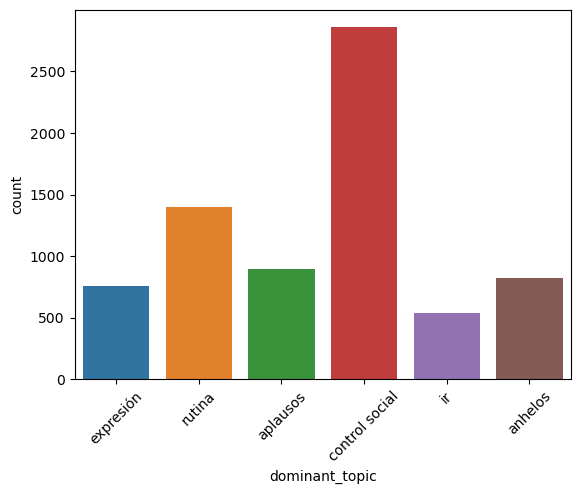

In [22]:
g = sns.countplot(dataset_tweet_topic.category)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show()

In [23]:
final_df = pd.concat([dataset_tweet_topic.category, dataset.text], axis=1)

In [24]:
final_df

,dominant_topic,text
0,expresión,"Si os falta papel higiénico, las banderas de E..."
1,rutina,"Himno de España, aplausos a sanitarios, el dis..."
2,aplausos,Hoy a las 22.00 se convocó salir al balcón par...
3,rutina,"""Aplausos en balcones de toda España para agra..."
4,rutina,"""Aplausos en balcones de toda España para agra..."
...,...,...
7263,control social,Quiero que se acabe todo esto cuanto antes tam...
7264,control social,El resumen es:\n\n1)Hay algo de vida inteligen...
7265,control social,madre mía estoy acordándome que cuando era peq...
7266,control social,Esta semana solo en mi calle y observando des...


In [25]:
#final_df.to_csv("final2_df.csv", sep=";")

# PCA

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
result = pca.fit_transform(nmf_output)

Text(0, 0.5, 'Component 2')

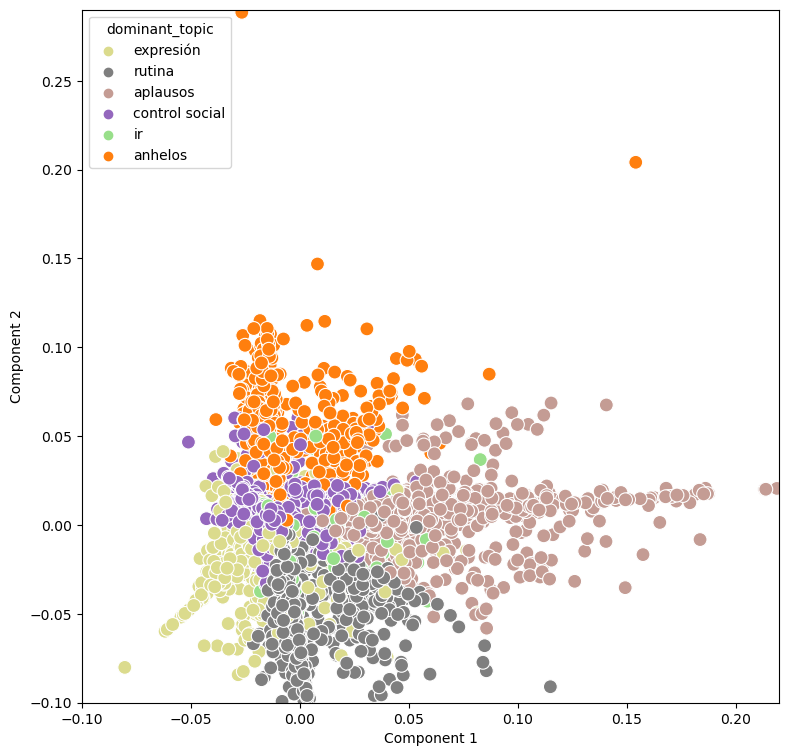

In [27]:
plt.subplots(figsize=(9, 9))
sns.scatterplot(
    x=result[:, 0], 
    y=result[:, 1], 
    hue=dataset_tweet_topic.category, 
    palette=sns.color_palette("tab20_r", 6),
#     style=df_tweet_topic.dominant_topic,
    s=100
)
plt.xlim(-0.1, 0.22)
plt.ylim(-0.10, 0.29)
plt.xlabel("Component 1")
plt.ylabel("Component 2")

# Tweets por tema

In [28]:
topic = "rutina"

for n in final_df[final_df.dominant_topic==topic].index:
    print(final_df.text.iloc[n] + "\n")

Himno de España, aplausos a sanitarios, el discurso de Lopera, cantes por sevillanas, la balcones de España el primer día de encierro.

"Aplausos en balcones de toda España para agradecer a los sanitarios"   https://twitter.com/i/events/1238956257907585024 …

"Aplausos en balcones de toda España para agradecer a los sanitarios"   https://twitter.com/i/events/1238956257907585024 …

Aplausos para quien nos cuidan desde la sanidad pública.
Cosquis para quien aplaude hoy desde su balcón y vota a partidos que recortan en sanidad. #COVIDー19 pic.twitter.com/er933PfJdm

Hasta que acaben los 15 días de confinamiento, saldremos todas las noches a las 22:00 a nuestras ventanas, balcones, etc a seguir regalando un GRAN APLAUSO 👏🏼 a todas las personas que están luchando contra el #COVID19 para darles las gracias por cuidar de todos #AplausoSanitario pic.twitter.com/hIafUnHdzk

Hoy a las 9:00 pm toda la gente de Barcelona se asomo por sus terrazas/balcones para aplaudir a los médicos que estan lucha